## Backpropagation practical exercise
Learning outcomes:
1. Understand how PyTorch uses computational graphs to implement backpropagation   
1. Apply PyTorch ```grad_fn``` to compute the gradient of any expression


## Backpropagation
 - We saw that PyTorch can compute the gradient to any function. 
 - To accomplish this, PyTorch uses three concepts:
 
 1. Computational graph
 1. "Database" of derivatives to **primitive** functions
 1. Chain rule

- Consider the following computations:
$$
\begin{align*}
a&=2\\
b&=4\\
c&=a+b\\
d&=\log(a)*\log(b)\\
e&=c*d
\end{align*}
$$
 

 Where $\log(x)$ is the log base two. 
 

- For every **primitive** operation, PyTorch "knows" its derivative. 
- For example, PyTorch has the following rules stored and can look them up when needed.

1. $\frac{\partial\log(x)}{\partial x}=\frac{1}{x*\ln(2)}$
1. $\frac{\partial (x*y)}{\partial x}=y$
1. $\frac{\partial (x*y)}{\partial y}=x$
1. $\frac{\partial (x+y)}{\partial x}=1$
1. $\frac{\partial (x+y)}{\partial y}=1$

- The PyTorch code corresponding to the example is shown below. Note:
1. For each **leaf** tensor ```X```, the gradient is stored in ```X.grad```
1. The values for **non-leaf** node ```Y``` is **not** saved, unless ```Y.retain_grad()``` is called

In [3]:
import torch
a=torch.tensor(2.,requires_grad=True)
b=torch.tensor(4.,requires_grad=True)
c=a+b
d=torch.log2(a)*torch.log2(b)
#d.retain_grad()
e=c*d
e.backward(retain_graph=True)
print(a.grad,b.grad)

tensor(10.6562) tensor(4.1640)


- How does ```backward``` work?
- Recursively calls the ```.grad_fn``` of each node in the graph
- We use ```.no_grad()``` so that PyTorch does not build a CG for for the computations below
- However, the code below will give an **error** because the graph is **destroyed** after the call to ```.backward()```

In [4]:
with torch.no_grad():
    dedc,dedd=e.grad_fn(torch.tensor(1.))
    print(dedc,dedd)
    

tensor(2.) tensor(6.)
(tensor(2.), tensor(2.))
(tensor(12.), tensor(6.))


- What can be done?
1. Either we rebuild the graph
1. Or we use the ```.retain_graph=True``` in the call to ```.backward()```
- Once that is done we see that the results are exactly as explained before in the figure

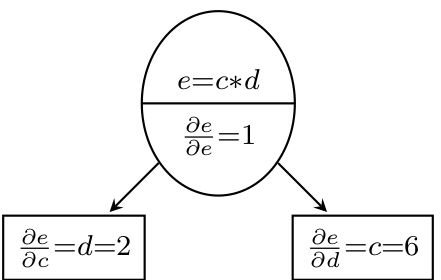

- Recall that the results for ```c.grad_fn``` are added to ```a``` and ```b```
- but the results for ```d.grad_fn``` are fed to **unnamed** intermediate nodes
- How does one proceed? How does PyTorch keep track?
- Actually PyTorch keeps track of the next ```grad_fn``` to call using ```next_functions``` object

In [5]:
with torch.no_grad():
    print(c.grad_fn(dedc))
    print(d.grad_fn(dedd))

(tensor(2.), tensor(2.))
(tensor(12.), tensor(6.))


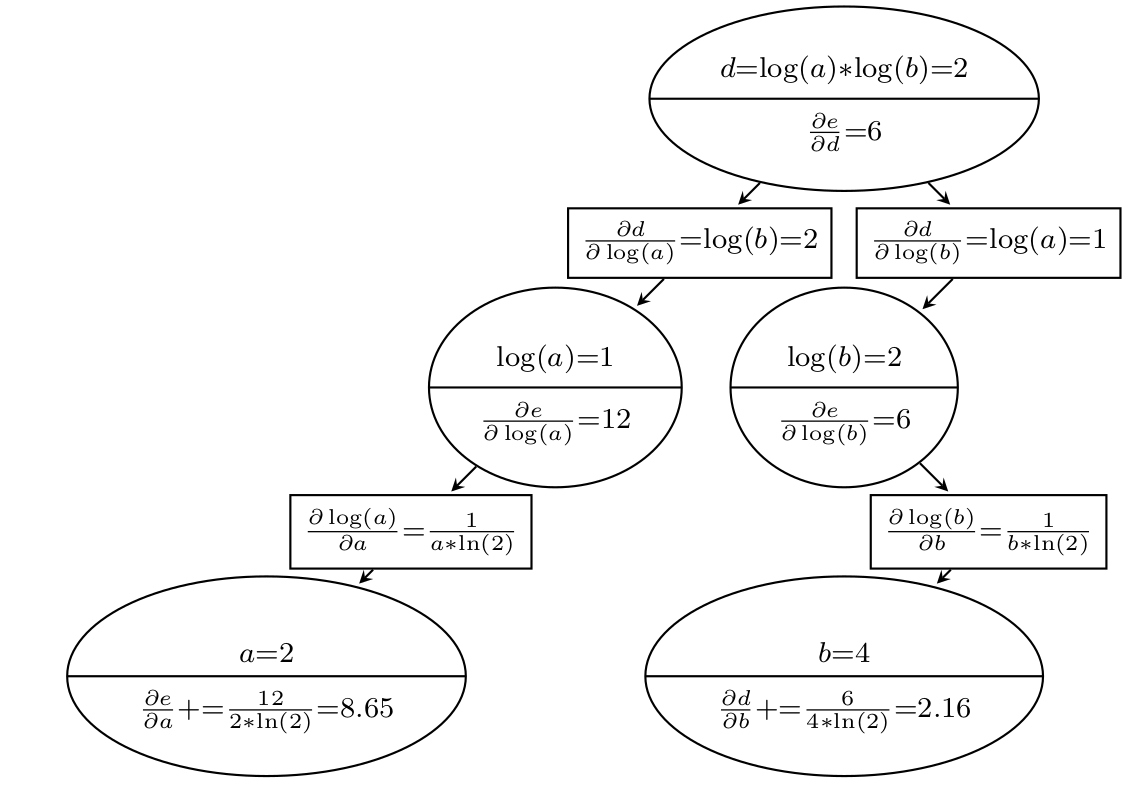

In [ ]:
print(d.grad_fn.next_functions)

- it is a tuple of pairs of the form (function,index)
- We can almost always ignore the index. For the vast majority of operations there is only one value 0
- Also, since most operations are binary the tuple is usually a pair
- In summary, for most operations that we encounter ```.next_functions``` returns a pair of pairs where the idex in each pair can be ignored

In [ ]:
with torch.no_grad():
    #the gradients are accumulated, we need to reset
    a.grad,b.grad=None,None
    # The "root" of the graph always has gradient of 1
    dedc,dedd=e.grad_fn(torch.tensor(1.))
    print("gradient of e wrt to c is={}, wrt to d={}".format(dedc,dedd))
    #gradient functions of C and D
    CgradFn=e.grad_fn.next_functions[0][0]
    DgradFn=e.grad_fn.next_functions[1][0]
    # apply to the last values
    deda,dedb=CgradFn(dedc)
    dedloga,dedlogb=DgradFn(dedd)
    
    # the "C" branch ends and accumulates in .grad
    accA1=CgradFn.next_functions[0][0]
    accB1=CgradFn.next_functions[1][0]
    accA1(deda)
    accB1(dedb)
    print("contribution of c branch to grad of a={}, to grad of b={}".format(a.grad,b.grad))
    # the "D" branch has unamed nodes, loga and logb
    LogAgradFn=DgradFn.next_functions[0][0]
    LogBgradFn=DgradFn.next_functions[1][0]

    #apply to the last values
    deda=LogAgradFn(dedloga)
    dedb=LogBgradFn(dedlogb)
    # the "D" branch ends and accumulates in .grad
    accA=LogAgradFn.next_functions[0][0]
    accA(deda)
    accB=LogBgradFn.next_functions[0][0]
    accB(dedb)
    print(a.grad,b.grad)


Rather than perform all the above operations manually, we can write a recursive function to go over all the nodes in the graph and computes the grads.

In [ ]:
def preorder(grad_fn,input):
    vals=grad_fn(input)
    if isinstance(vals,tuple):
        for (f,idx),val in zip(grad_fn.next_functions,vals):
            preorder(f,val)
    else:
        preorder(grad_fn.next_functions[0][0],vals)

In [ ]:
with torch.no_grad():
    a.grad,b.grad=None,None
    preorder(e.grad_fn,torch.tensor(1.))

In [ ]:
print(a.grad,b.grad)